<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/Following_JAX_Tutorial_Autodiff_Cookbook_Custom_derivative_rules_for_JAX_transformable_Python_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autodiff Cookbook

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.key(0)

## Gradient

In [3]:
import matplotlib.pyplot as plt

0.070650816


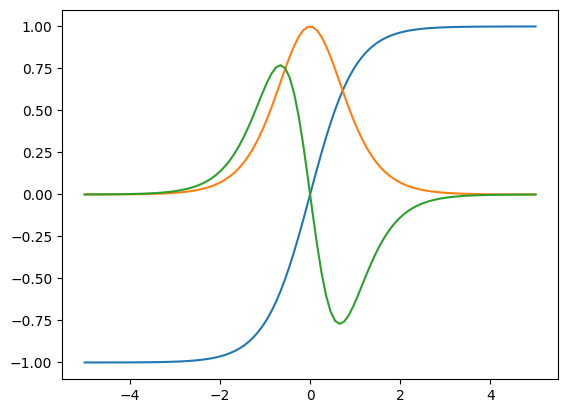

In [9]:
grad_tanh = grad(jnp.tanh)
xs = jnp.linspace(-5, 5, 100)
ys = jnp.tanh(xs)

print(grad_tanh(2.0))
plt.plot(xs, ys)
plt.plot(xs, vmap(grad_tanh)(xs))
plt.plot(xs, vmap(grad(grad(jnp.tanh)))(xs))

In [8]:
print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

-0.13621868
0.25265405


22:32 -
There are two ways to define differentiation rules in JAX:

*   using `jax.cusom_jvp` and `jax.custom_vjp` to define custom differentiation rules for Python functions that are already JAX-transformable;
*   defining new `core.Primitive` instances along with their transformation rule.



In [10]:
def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

In [11]:
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [12]:
W_grad = grad(loss, argnums=0)(W, b)
print('W_grad', W_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]


In [13]:
# argnums=0 is default
W_grad = grad(loss)(W, b)
print('W_grad', W_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]


In [14]:
b_grad = grad(loss, argnums=1)(W, b)
print('b_grad', b_grad)

b_grad -0.29227245


In [15]:
W_grad, b_grad = grad(loss, argnums=(0, 1))(W, b)
print('W_grad', W_grad)
print('b_grad', b_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245


## Differentiating w.r.t. nested lists, tuples, and dicts

Differentiating w.r.t. to standard Python containers just works, so use tuples, lists, and dicts however you like.

In [16]:
def loss2(params_dict):
  preds = predict(params_dict['W'], params_dict['b'], inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b}))

{'W': Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32), 'b': Array(-0.29227245, dtype=float32)}


## Evaluate a function and its gradient using `value_and_grad`

In [17]:
from jax import value_and_grad
loss_value, Wb_grad = value_and_grad(loss, (0, 1))(W, b)
print('loss value', loss_value)
print('loss value', loss(W, b))

loss value 3.0519385
loss value 3.0519385


## Check against numerical differences

In [18]:
eps = 1e-4

b_grad_numerical = (loss(W, b + eps / 2.) - loss(W, b - eps / 2.)) / eps
print('b_grad_numerical', b_grad_numerical)
print('b_grad_autodiff', grad(loss, 1)(W, b))

b_grad_numerical -0.29325485
b_grad_autodiff -0.29227245


In [19]:
key, subkey = random.split(key)
vec = random.normal(subkey, W.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
W_grad_numerical = (loss(W + eps / 2. * unitvec, b) - loss(W - eps / 2. * unitvec, b)) / eps
print('W_dirderiv_numerical', W_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(loss)(W, b), unitvec))


W_dirderiv_numerical -0.2002716
W_dirderiv_autodiff -0.19909117


In [20]:
from jax.test_util import check_grads
check_grads(loss, (W, b), order=2)

## Hessian-vector products with `grad`-of-grad

In [21]:
def hvp(f, x, v):
  return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

## Jacobians and Hessians using `jacfwd` and `jacrev`

In [22]:
from jax import jacfwd, jacrev

# Isolate function wrom weight matrix to the prediction
f = lambda W: predict(W, b, inputs)

J = jacfwd(f)(W)
print("jacfwd result, with shape", J.shape)
print(J)

J = jacrev(f)(W)
print("jacrev result, with shape", J.shape)
print(J)


jacfwd result, with shape (4, 3)
[[ 0.05981758  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188288  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]
jacrev result, with shape (4, 3)
[[ 0.05981757  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188289  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]


In [23]:
def predict_dict(params, inputs):
  return predict(params['W'], params['b'], inputs)

J_dict = jacrev(predict_dict)({'W': W, 'b': b}, inputs)
for k, v in J_dict.items():
  print(f"Jacobian from {k} to logits is")
  print(v)

Jacobian from W to logits is
[[ 0.05981757  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188289  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]
Jacobian from b to logits is
[0.11503381 0.04563541 0.23439017 0.00189771]


Using a composition of two of these functions gives us a way to compute dense Hessian matrices:

In [25]:
def hessian(f):
  return jacfwd(jacrev(f))

# W.shape: (3, ), inputs: (N, 3), output of f: (N, )
# Jacobian of f w.r.t. W (N, 3)
# Jacobian of Jacobian of f (N, 3, 3)
H = hessian(f)(W)
print("hessian, with shape", H.shape)
print(H)

hessian, with shape (4, 3, 3)
[[[ 0.02285465  0.04922541  0.03384247]
  [ 0.04922541  0.10602397  0.07289147]
  [ 0.03384247  0.07289147  0.05011288]]

 [[-0.03195215  0.03921401 -0.00544639]
  [ 0.03921401 -0.04812629  0.00668421]
  [-0.00544639  0.00668421 -0.00092836]]

 [[-0.01583708 -0.00182736  0.03959271]
  [-0.00182736 -0.00021085  0.00456839]
  [ 0.03959271  0.00456839 -0.09898177]]

 [[-0.00103524  0.00348343 -0.00194457]
  [ 0.00348343 -0.01172127  0.0065432 ]
  [-0.00194457  0.0065432  -0.00365263]]]


Typically, forward-over-reverse is the most efficient because in the inner Jacobian computation we're often differentiating a function wide Jacobian.

# How it's made: two foundational autodiff functions

## Jacobian-Vector products (JVPs, aka forward-mode autodiff)

### JVPs in Math

Mathematically, given a function $f: R^n → R^m$, the Jacobian of $f$ evaluated at a point $x ∈ R^n$ is often thought of as a matrix in $𝐑^m × 𝐑^n$. But we can also think of f as a linear map from R^n to R^m.

In [26]:
from jax import jvp

In [27]:
f = lambda W: predict(W, b, inputs)

key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# jvp: (x, v) -> (f(x), grad(f)(x)v)
y, u = jvp(f, (W,), (v,))